In [34]:
import yfinance as yf

# Retrieve historical stock data
symbol = 'AAPL'  # Replace with your desired stock symbol
start_date = '2000-01-01'  # Replace with your desired start date
data = yf.download(symbol, start=start_date)

data['Percent Change'] = data['Adj Close'].pct_change()
data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Percent Change
Date,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.849468,535796800,NaN
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.777850,512377600,-0.084310
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.789232,778321600,0.014633
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.720933,767972800,-0.086538
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.755083,460734400,0.047369


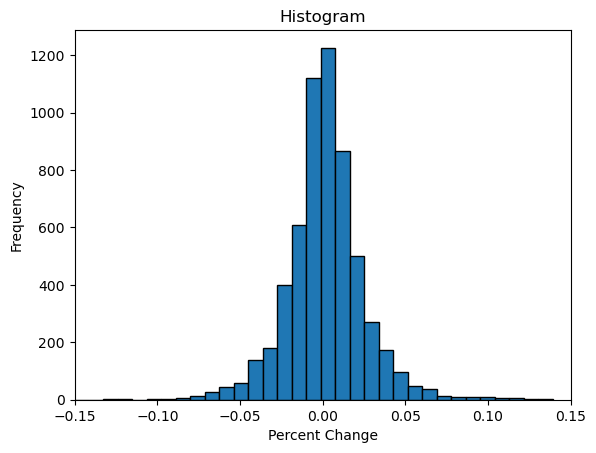

In [35]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(data["Percent Change"], bins=75, edgecolor='black')

plt.xlim(-0.15, 0.15)

# Adding labels and title
plt.xlabel('Percent Change')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the histogram
plt.show()


                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000             0.033592
5d_close_future_pct      0.033592             1.000000


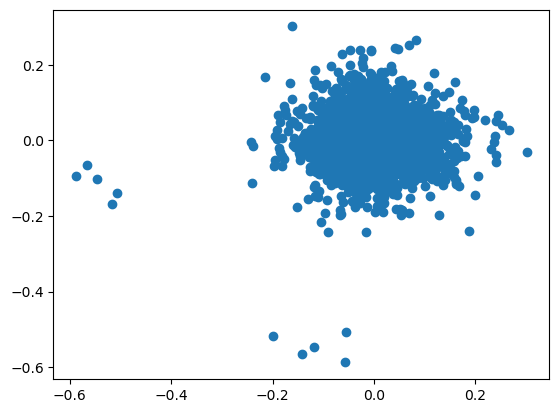

In [36]:
data['5d_future_close'] = data['Adj Close'].shift(-5)
data['5d_close_future_pct'] = data['5d_future_close'].pct_change(5)
data['5d_close_pct'] = data['Adj Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = data[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(data['5d_close_pct'], data['5d_close_future_pct'])
plt.show()

In [37]:
import talib
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    data['ma' + str(n)] = talib.SMA(data['Adj Close'].values,
                              timeperiod=n) / data['Adj Close']
    # Create the RSI indicator
    data['rsi' + str(n)] = talib.RSI(data['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [38]:
# Drop all na values
data = data.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = data[feature_names]
targets = data['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + list(features)
feat_targ_df = data[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000      0.006085 -0.004571  0.027743   
5d_close_pct                    0.006085      1.000000 -0.848018  0.631520   
ma14                           -0.004571     -0.848018  1.000000 -0.804841   
rsi14                           0.027743      0.631520 -0.804841  1.000000   
ma30                           -0.011736     -0.579347  0.796760 -0.817995   
rsi30                           0.026236      0.474322 -0.649256  0.930299   
ma50                           -0.030915     -0.434131  0.623554 -0.745723   
rsi50                           0.020337      0.379293 -0.536980  0.827911   
ma200                           0.001519     -0.191064  0.303312 -0.458455   
rsi200                          0.005781      0.200365 -0.302276  0.513974   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct -0.011736  0.026236 -0.030915  0.020337  0.00151

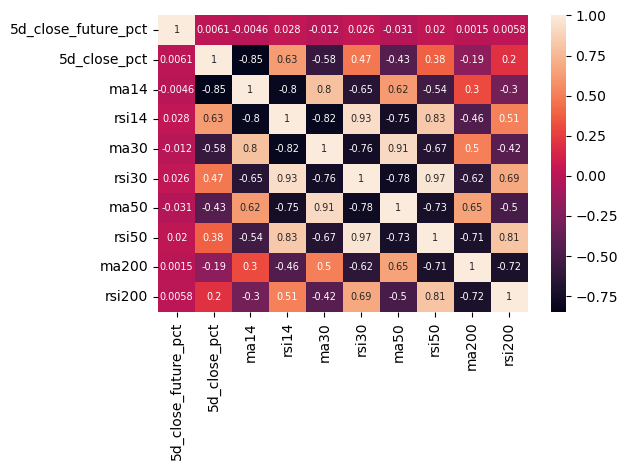

<Figure size 640x480 with 0 Axes>

In [39]:
import seaborn as sns

# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True, annot_kws = {"size": 7})
plt.yticks(rotation=0, size = 10); plt.xticks(rotation=90, size = 10)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

In [40]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(5683, 10) (4830, 10) (853, 10)


In [41]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.008
Model:                             OLS   Adj. R-squared:                  0.006
Method:                  Least Squares   F-statistic:                     4.353
Date:                 Tue, 30 May 2023   Prob (F-statistic):           1.13e-05
Time:                         08:10:28   Log-Likelihood:                 7623.6
No. Observations:                 4830   AIC:                        -1.523e+04
Df Residuals:                     4820   BIC:                        -1.516e+04
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0736      0.045    

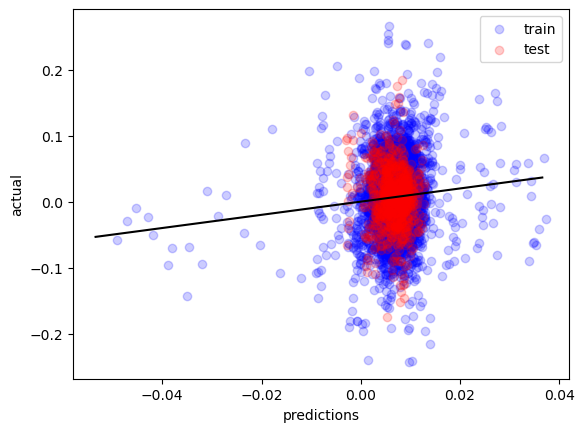

In [42]:
import numpy as np
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha = 0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

In [60]:
from sklearn.tree import DecisionTreeRegressor

# Loop through a few different max depths and check the performance
for d in [1, 2, 3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth = d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 1
0.0059623140917370865
-0.02132834306159248 

max_depth= 2
0.02509709828962481
-0.014789345476493576 

max_depth= 3
0.03896241902352049
-0.01996781790846458 

max_depth= 5
0.0900013101918149
-0.021174798592722865 

max_depth= 10
0.2627914751389777
-0.1273111874824855 



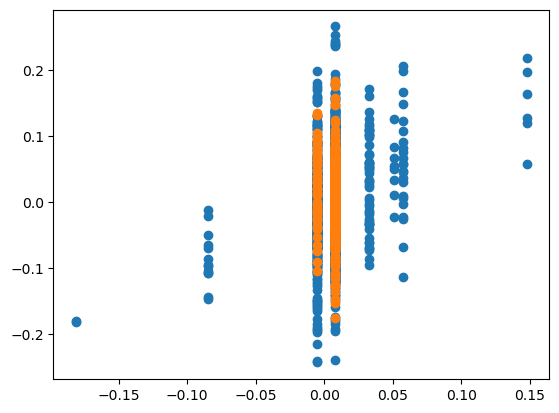

In [64]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth = 3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

In [45]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9063775354269046
-0.17873119175883923


In [46]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.02272975851268999 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


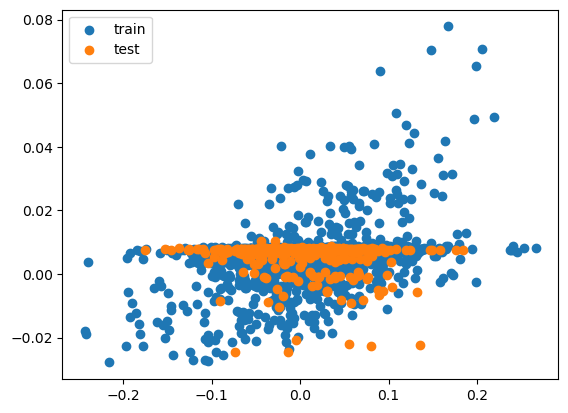

In [47]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label = 'test')
plt.legend()
plt.show()

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.08075012962733663
-0.02929827137224894


In [55]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::1]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

IndexError: index 9 is out of bounds for axis 0 with size 9